Tests for mod_mod algo

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib

import itertools
import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 15})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
aas = 'ABCDEF'
n_aas = 6
dic = {
    'AAA': torch.tensor(0.99),
}
for a, b, c in itertools.product(aas, repeat=3):
    k = a + b + c
    if k in dic:
        continue
    elif a in 'ABC' and b in 'ABC' and c in 'ABC':
        dic[k] = 0.01
    elif a in 'DEF' and b in 'DEF' and c in 'ABC':
        dic[k] = torch.tensor(0.98)
    elif a in 'AB' and b in 'EF' and c in 'EF':
        dic[k] = torch.tensor(0.98)
    else:
        dic[k] = torch.tensor(0.0)

In [4]:
L = 3
ground = [(aa, i) for aa in aas for i in range(L)]

In [5]:
seed = helpers.get_seed(dic)
seed

[('A', 0), ('A', 1), ('A', 2)]

In [6]:
n = 10

def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

alpha = scipy.optimize.minimize(ddr, 200, args=(n,), method='Powell')['fun']
alpha = -torch.Tensor(alpha)
alpha



tensor(1.00000e-03 *
       4.2262)

In [7]:
def get_alpha(dic, n):
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

    
%time alpha3 = -get_alpha(dic, n)
alpha3

CPU times: user 3.85 ms, sys: 3.18 ms, total: 7.03 ms
Wall time: 4.46 ms


9.333322871822924

In [8]:
np.random.seed(402136)

starts = [[], seed, ground]
for m in [1, 3, 5, 7, 9, 11, 13]:
    A = np.random.choice(L * 6, m + 3, replace=False)
    A = [ground[a] for a in A]
    starts.append(A)
    
ns = [2, 5, 10, 50, 100, 216, 500, np.inf]

In [9]:
def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

alphas = [scipy.optimize.minimize(ddr, 125, args=(n,), method='Powell')['fun'] for n in ns[:-1]]
alphas = [-torch.Tensor(alpha) for alpha in alphas] + [torch.tensor(0.0)]
alphas

[tensor(0.1250), tensor(1.00000e-02 *
        1.7235), tensor(1.00000e-03 *
        4.2262), tensor(1.00000e-04 *
        1.6802), tensor(1.00000e-05 *
        4.1996), tensor(1.00000e-06 *
        9.0008), tensor(1.00000e-06 *
        1.6797), tensor(0.)]

In [10]:
def get_alpha(dic, n):
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

    
%time alpha23 = [-get_alpha(dic, n) for n in ns]
alpha23

CPU times: user 14.9 ms, sys: 3.06 ms, total: 17.9 ms
Wall time: 15.4 ms


[11.109375,
 9.797731018066406,
 9.333322871822924,
 8.97381437632786,
 8.930412873167198,
 8.907314310757101,
 7.642952959691888,
 -0.0]

In [11]:
S = L * n_aas
S = torch.tensor(S).double()
beta = 2 * torch.sqrt(S - 1) - torch.sqrt(S) - torch.sqrt(S - 2)

In [12]:
df = pd.DataFrame(columns=['n', 'start', 'L', 'algorithm', 'obj'])

In [13]:
for n in ns:
    for S in starts:
        _, objs = opt.greedy(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [14]:
opt = importlib.reload(opt)

for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr_add', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [15]:
opt = importlib.reload(opt)

for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n), remove=True)
        other = pd.DataFrame([[n, S, L, 'gr_rem', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [16]:
%%time
opt = importlib.reload(opt)

for alpha, n in zip(alphas, ns):
    for S in starts:
        _, objs = opt.supsub(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-dc', objs[-1]]], columns=df.columns)
        df = df.append(other)

KeyboardInterrupt: 

In [17]:
%%time
opt = importlib.reload(opt)

for alpha, n in zip(alpha23, ns):
    for S in starts:
        _, objs = opt.supsub(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-ds', objs[-1]]], columns=df.columns)
        df = df.append(other)

KeyboardInterrupt: 

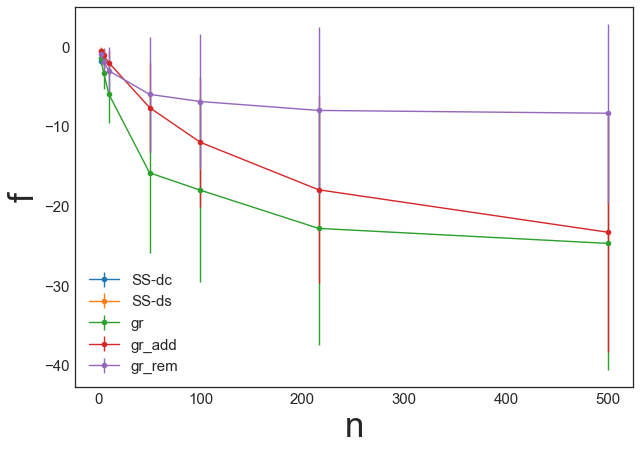

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for al in sorted(set(df['algorithm'])):
    df_ = df[df['algorithm'] == al]
    means = [np.mean(df_[df_['n'] == n]['obj']) for n in ns[:-1]]
    stds = [np.std(df_[df_['n'] == n]['obj']) for n in ns[:-1]]

    _ = ax.errorbar(ns[:-1], means, yerr=stds, fmt='-o', label=al, capsize=30)
_ = ax.set_xlabel('n')
_ = ax.set_ylabel('f')
_ = ax.legend()